In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import kagglehub
from tqdm import tqdm
from tqdm.keras import TqdmCallback
import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Load Mask and Images and Padding to Square

In [39]:
def remove_icc_profile(image):
    """รับ numpy array ของภาพแล้วลบ ICC Profile (ไม่บันทึกไฟล์)"""
    try:
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # แปลงเป็น PIL Image
        img = img.convert("RGB")  # ลบ ICC Profile โดยแปลงเป็น RGB
        img_np = np.array(img)  # แปลงกลับเป็น NumPy array
        return cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # แปลงกลับเป็น BGR
    except Exception as e:
        print(f"Error removing ICC profile: {e}")
        return image  # ถ้าลบไม่ได้ ให้ใช้ภาพเดิม
    
def resize_image(image, target_size):
    """ปรับขนาดภาพให้พอดีกับ target_size โดยรักษาอัตราส่วนและเติมขอบสีดำ"""
    if image is None:
        return None

    h, w = image.shape[:2]
    scale = target_size / max(h, w)
    new_h, new_w = int(round(h * scale)), int(round(w * scale))
    
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # คำนวณ Padding
    pad_top = (target_size - new_h) // 2
    pad_bottom = target_size - new_h - pad_top
    pad_left = (target_size - new_w) // 2
    pad_right = target_size - new_w - pad_left
    
    return cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

def process_image(image_path, target_size):
    """โหลดภาพ, ลบ ICC Profile และปรับขนาด"""
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = remove_icc_profile(image)  # ลบ ICC Profile
    return resize_image(image, target_size)  # ปรับขนาดภาพ

def load_images(images_dir, mask_dir, target_size=512):
    """โหลดภาพจากโฟลเดอร์, ลบ ICC Profile, และปรับขนาด พร้อมแสดง progress bar"""
    image_files = [img for img in os.listdir(images_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    mask_files = [mask for mask in os.listdir(mask_dir) if mask.lower().endswith(('.png', '.jpg', '.jpeg'))]

    images = [
        process_image(os.path.join(images_dir, img), target_size)
        for img in tqdm(image_files, desc="Processing Images", unit="img")  # ✅ Add progress bar
    ]
    masks = [
        process_image(os.path.join(mask_dir, mask), target_size)
        for mask in tqdm(mask_files, desc="Processing Masks", unit="mask")  # ✅ Add progress bar
    ]

    images = [img for img in images if img is not None]
    masks = [mask for mask in masks if mask is not None]

    return images, masks

Processing Masks: 100%|██████████| 166/166 [00:39<00:00,  4.19mask/s]


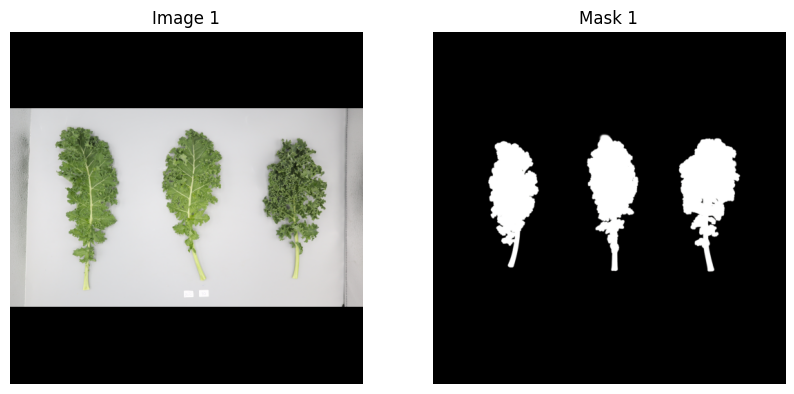

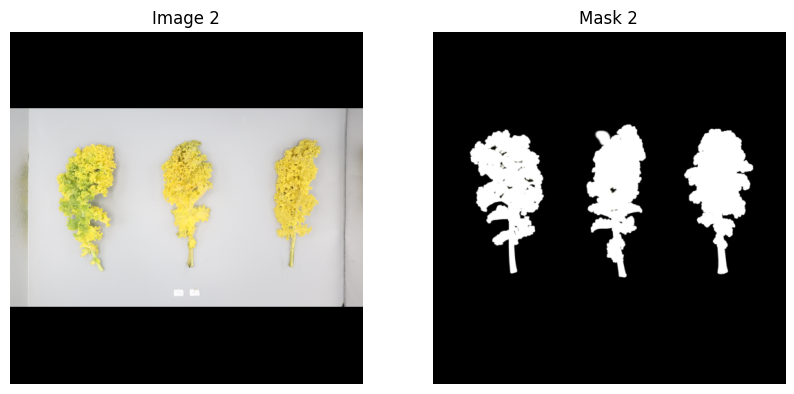

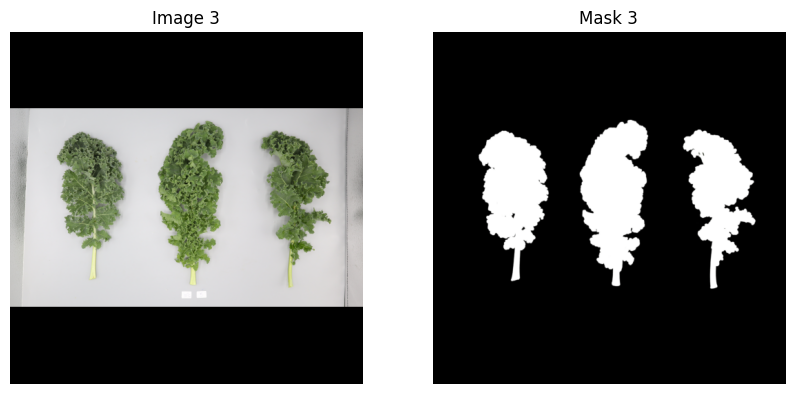

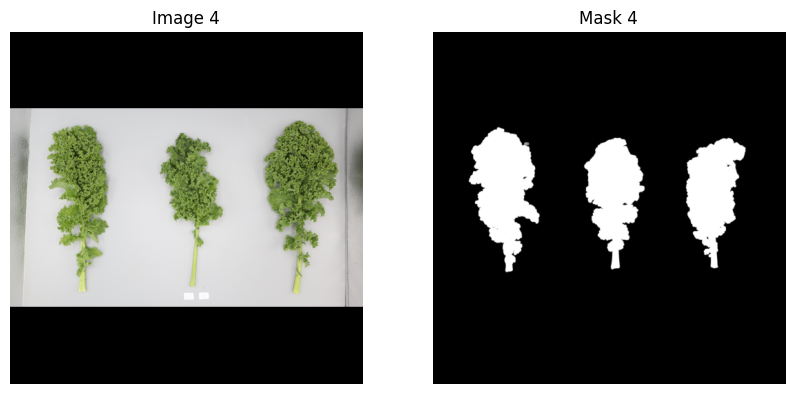

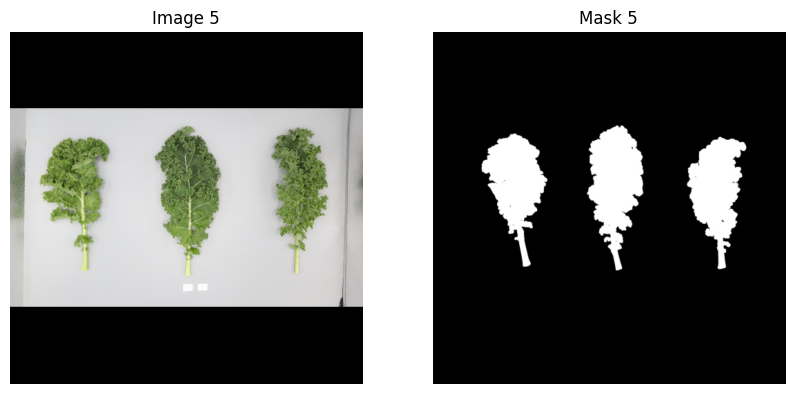

In [40]:

def show_images(images, masks, max_images=5):
    """แสดงภาพและมาสก์ด้วย matplotlib (สูงสุด max_images ภาพ)"""
    if not images or not masks:
        print("No valid images or masks found.")
        return

    num_images = min(len(images), len(masks), max_images)  # แสดงได้สูงสุด 5 ภาพ หรือเท่าที่มี

    for i in range(num_images):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # แปลง BGR -> RGB
        axes[0].set_title(f"Image {i+1}")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(masks[i], cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Mask {i+1}")
        axes[1].axis("off")

        plt.show()  # แสดงผลทีละภาพ
        
images, masks = load_images('resources/images', 'resources/masks', target_size=512)
show_images(images, masks)  # ใช้ plt.show() แทน imwrite()


## Train and Evaluate Model

In [43]:
def load_model():
    """Load DeepLabV3+ and modify the output shape to match the target masks."""
    path = kagglehub.model_download("keras/deeplabv3plus/keras/deeplab_v3_plus_resnet50_pascalvoc")
    model = tf.keras.models.load_model(path)

    # Resize output to match mask dimensions
    resized_output = tf.keras.layers.Resizing(512, 512)(model.output)  # Resize prediction to 512x512

    # Reduce the number of output channels to match the number of classes (e.g., 3 for RGB masks)
    num_classes = 3  # Change this to 1 if using grayscale masks
    final_output = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(resized_output)  # Classifier layer

    # Define new model with corrected output shape
    model = keras.Model(inputs=model.input, outputs=final_output)

    return model

def prepare_dataset(images, masks, batch_size=2):
    """Create a TensorFlow dataset from NumPy arrays."""
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def train_test_split(images, masks, test_size):
    """Split images and masks into training and testing sets."""
    images = np.array(images)  # ✅ Convert list to NumPy array
    masks = np.array(masks)    # ✅ Convert list to NumPy array
    n = len(images)
    indices = np.random.permutation(n)
    n_test = int(n * test_size)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    train_images, train_masks = images[train_indices], masks[train_indices]
    test_images, test_masks = images[test_indices], masks[test_indices]
    print(f"Train samples: {len(train_images)}")
    print(f"Validation samples: {len(test_images)}")
    
    return train_images, train_masks, test_images, test_masks

In [44]:
# Load and compile the model
model = load_model()
model.compile(loss="categorical_crossentropy", optimizer='adam')
# Split the data into train and test sets
train_images, train_masks, test_images, test_masks = train_test_split(images, masks, 0.05)
    
# Prepare TensorFlow datasets for training and validation
train_dataset = prepare_dataset(train_images, train_masks, batch_size=2)
test_dataset = prepare_dataset(test_images, test_masks, batch_size=2)
    
# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='../../models/best_model.keras',  # Path where the model will be saved
    monitor='val_loss',                    # Monitor the validation loss
    verbose=1,                             # Verbose output on saving
    save_best_only=True,                   # Only save when the model improves
    mode='min'                             # Lower loss is better
)
    
# Train the model with the checkpoint callback
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[checkpoint]
)
    
# Optionally, save the final model
keras.saving.save_model(model, "../../models/deeplabv3_trained.keras")
print("Training complete!")

Train samples: 158
Validation samples: 8
Epoch 1/50


/home/jemiezler/Dev/Kale-SeniorProject/venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2196']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)
I0000 00:00:1740649458.429728   86703 service.cc:148] XLA service 0x7f9cc4001730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740649458.430467   86703 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-27 16:44:19.080094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740649462.343844   86703 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-27 16:44:30.215403: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory try

16/79 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - loss: 203.7720

KeyboardInterrupt: 